# Phase weighted stacking

In [34]:
import xarray as xr
from ooi_hydrophone_cloud import utils
import odlintake
from dask.distributed import Client
import pandas as pd
from ni_tools import calculate
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import xrsignal

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46121,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.79 GiB
Comm: tcp://127.0.0.1:37283,Total threads: 4
Dashboard: http://127.0.0.1:37757/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:34833,


In [71]:
ds = odlintake.open_ooi_lfhydrophones()
ds_sliced = utils.slice_ds(ds, pd.Timestamp('2018-02-01'), pd.Timestamp('2018-02-02'), include_coord=False)[['AXCC1', 'AXEC2']]

In [80]:
ds.chunk({'time':3600*200*24})['AXEC2'][int(1e9):int(1e9+3600*24*200)].load()

<xarray.DataArray 'AXEC2' (time: 17280000)>
array([-11.20318794, -11.18419456, -11.24158764, ..., -11.26016808,
       -11.13258266, -11.24076176])
Dimensions without coordinates: time

In [72]:
NCCFs_unstacked = calculate.compute_NCCF_stack(ds_sliced, compute=False, stack=False, fcs=[1,90])

In [73]:
inst_ang = xr.DataArray(np.angle(xrsignal.hilbert(NCCFs_unstacked, 'delay')), dims=NCCFs_unstacked.dims, coords=NCCFs_unstacked.coords)
pw = np.abs(np.exp(1j*inst_ang).mean('time'))

NCCF_lin = NCCFs_unstacked.mean('time')
NCCF_pws = NCCF_lin*pw

(-6.0, 6.0)

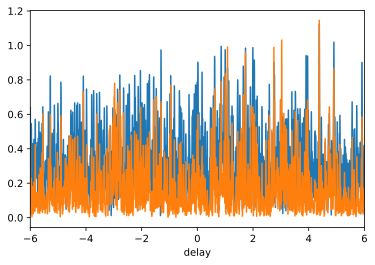

In [74]:
np.abs(xrsignal.hilbert((NCCF_lin.differentiate('delay')/NCCF_lin.differentiate('delay').max()), 'delay')).plot()
np.abs(xrsignal.hilbert((NCCF_pws.differentiate('delay')/NCCF_pws.differentiate('delay').max()), 'delay')).plot()
plt.xlim([-6,6])

In [25]:
NCCF_pws = calculate.compute_NCCF_stack(ds_sliced, compute=False, stack=True, stack_type='phase_weighted', fcs=[1,90]).mean('time').compute()
NCCF_lin = calculate.compute_NCCF_stack(ds_sliced, compute=False, stack=True, stack_type='linear', fcs=[1,90]).mean('time').compute()

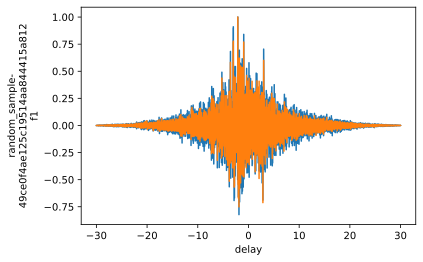

In [26]:
(NCCF_lin/NCCF_lin.max()).plot()
(NCCF_pws/NCCF_pws.max()).plot()

In [83]:
fn= '/datadrive/HYCOM_data/Axial_Seamount_earthengine/*.nc'
hycom = xr.open_mfdataset(fn)

In [95]:
3*hycom['salinity'].std().compute()

<xarray.DataArray 'salinity' ()>
array(2.42166635)

In [97]:
hycom['salinity'].mean().compute()

<xarray.DataArray 'salinity' ()>
array(33.17219827)

In [98]:
from oceans import sw_extras as sw

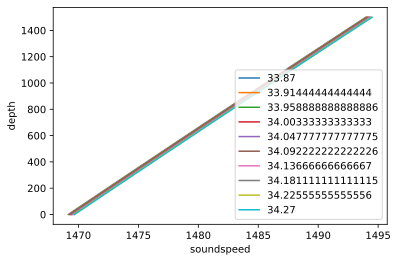

In [133]:
for sal in list(np.linspace(34.07-0.2, 34.07+0.2, 10)):
    plt.plot(sw.soundspeed(np.ones(100)*sal, np.ones(100)*5, np.linspace(0,1500,100)), np.linspace(0,1500,100), label=sal)
    
plt.ylabel('depth')
plt.xlabel('soundspeed')
plt.legend()


(34.25, 34.0)

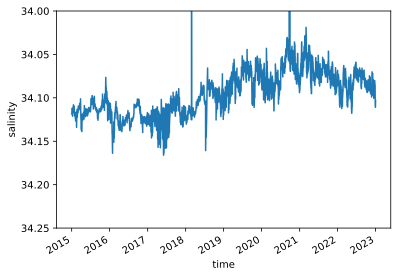

In [120]:
hycom['salinity'].interp({'depth':np.arange(0,1500)}, method='linear').mean('depth').plot()
plt.ylim([34.25, 34])

In [122]:
hycom['salinity'].interp({'depth':np.arange(0,1500)}, method='linear').mean('depth').mean().compute()

<xarray.DataArray 'salinity' ()>
array(34.07945617)

In [124]:
hycom['salinity'].interp({'depth':np.arange(0,1500)}, method='linear').mean('depth').std().compute()

<xarray.DataArray 'salinity' ()>
array(0.18871203)